# Test

This notebook tests the functions and classes in myimagelib.

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../src"))
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from skimage.io import imread
google_download_handle = "https://drive.google.com/uc?export=download&id={}"
import numpy as np
import cv2

In [2]:
from myimagelib import readdata, show_progress, to8bit, bestcolor, rawImage, imfindcircles, xy_bin

### `readdata`

In [3]:
l = readdata(".", "ipynb")
l

,Name,Dir
0,compact_PIV,.\compact_PIV.ipynb
1,test,.\test.ipynb


### `show_progress`

In [25]:
show_progress(0.5, label="test", bar_length=80)

### `to8bit`

1. Download the test image.

In [32]:
# Download condensation image from the cloud
url = google_download_handle.format("1OTTXhvSrfgPmFcqjTQEaam9e5vgSEP79")  # replace with your image URL
response = requests.get(url, stream=True)

if response.status_code == 200:
    img = imread(BytesIO(response.content))
    print("Image downloaded successfully.")
else:
    print("Failed to download image.")

Image downloaded successfully.


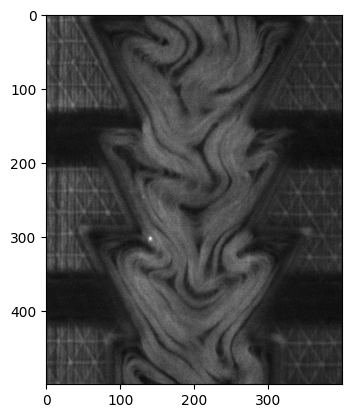

In [33]:
plt.imshow(img, cmap="gray")

2. Convert to 8-bit and enhance the contrast.

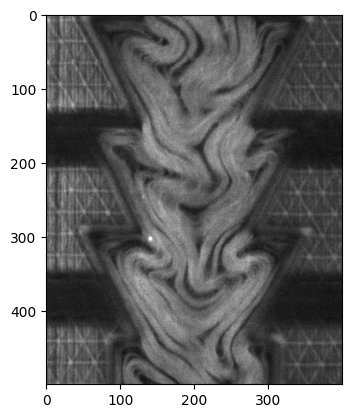

In [49]:
img8 = to8bit(img)
plt.imshow(img8, cmap="gray")

### `imfindcircles`

1. Download the test image.

In [3]:
# Download condensation image from the cloud
url = google_download_handle.format("1LFRt5ozQjJ_WVrWBoPQOFVNl5ZWb8ytP")  # replace with your image URL
response = requests.get(url, stream=True)

if response.status_code == 200:
    img = imread(BytesIO(response.content))
    print("Image downloaded successfully.")
else:
    print("Failed to download image.")

Image downloaded successfully.


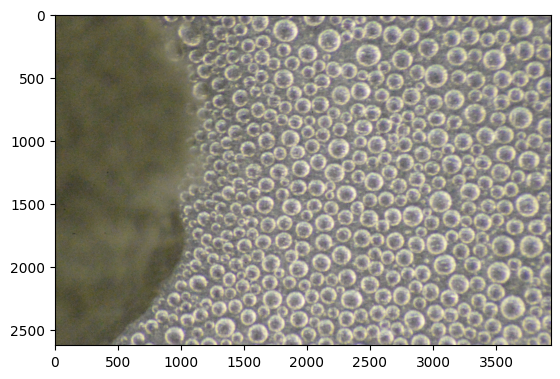

In [4]:
plt.imshow(img)

2. Convert to gray

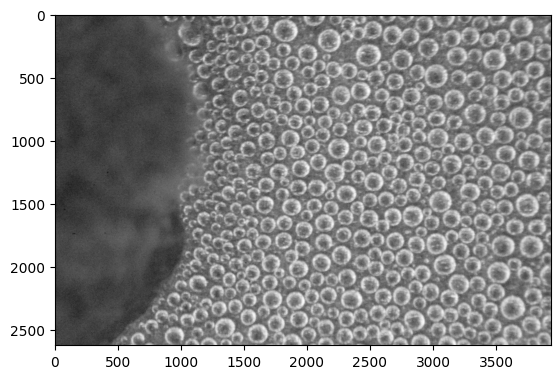

In [5]:
# convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap="gray")

3. Find circles!

In [6]:
df = imfindcircles(gray, [50, 100], sensitivity=0.7, smooth_window=21)

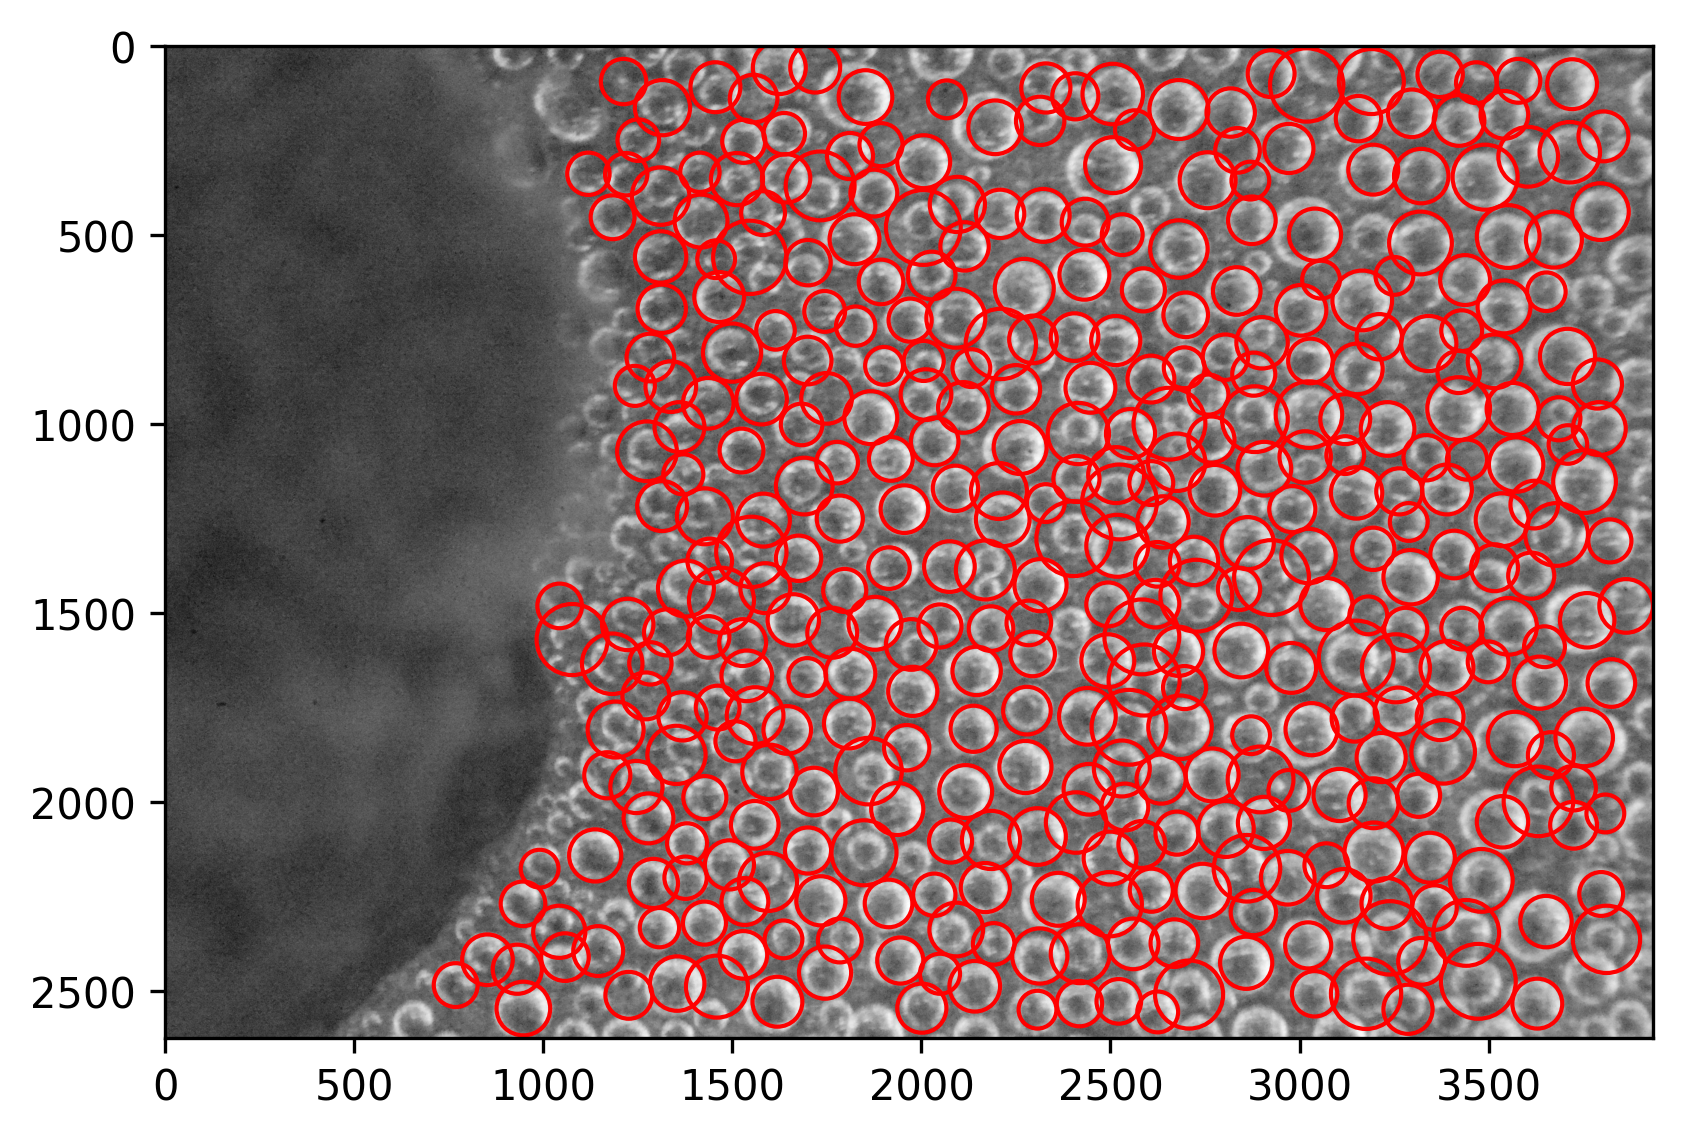

In [7]:
plt.figure(dpi=300)
plt.imshow(gray, cmap='gray')
for _, row in df.iterrows():
    circ = plt.Circle((row["x"], row["y"]), row["r"], color='r', fill=False)
    plt.gca().add_patch(circ)

### `xy_bin`

1. Generate dense data

In [3]:
# craete a dense data
s = int(1e6)
x = np.arange(s)
y = np.sin(0.00001*x) + np.random.rand(s)*.1

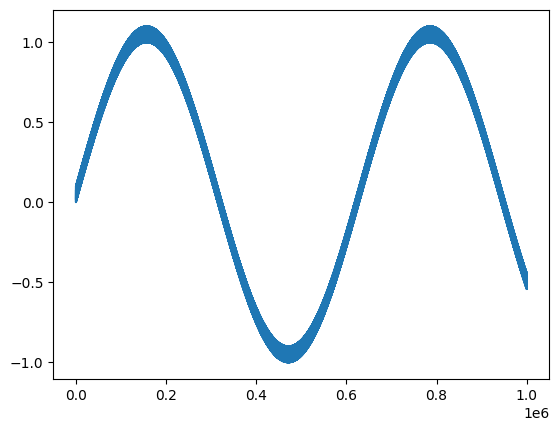

In [4]:
plt.plot(x, y)

2. Bin the data from 1e6 points to 50 points.

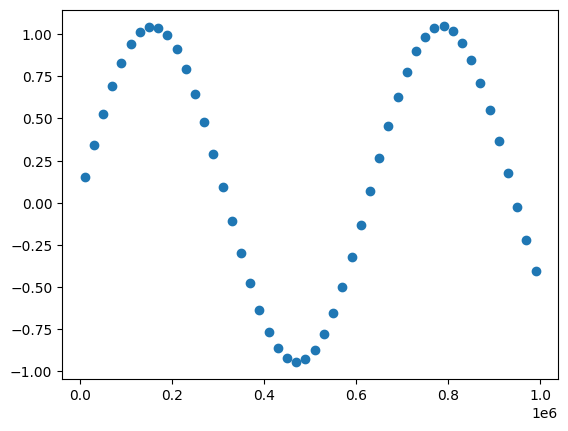

In [8]:
xb, yb = xy_bin(x, y, n=50, mode="lin")
plt.scatter(xb, yb)

### `bestcolor`

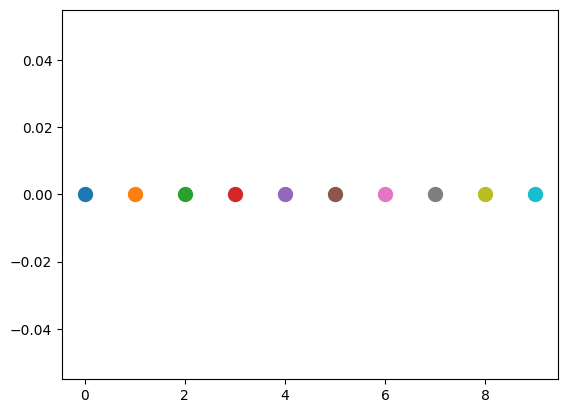

In [11]:
for i in range(10):
    plt.scatter(i, 0, s=100, color=bestcolor(i))